## This file explores all the regression based approaches

In [33]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

import xgboost as xgb


## What are we predicting - 



### ⚙️ Understanding Flute Wear and Why We Predict Its Difference

Each cutter has **three flutes** — the spiral cutting edges that remove material during milling.  
As the tool operates, each flute experiences wear independently, depending on its contact angle and loading.  
The raw flute wear values recorded after every cut are **cumulative measurements**, always increasing over time.  
To make the prediction more meaningful, we model the **incremental change** in wear between successive cuts (`flute[i] - flute[i−1]`),  
since this directly represents the **rate of degradation per operation**, which is smoother, less biased by time, and more correlated with the measured forces, vibrations, and acoustic features.


In [34]:
RAW_DIR = "c1"
PRE_DIR = "preprocess"

# collect all preprocessed feature files and their matching wear entries
features, labels = [], []

wear_df = pd.read_csv('c1_wear.csv')
wear_df.columns = wear_df.columns.str.lower()

files = sorted([f for f in os.listdir(PRE_DIR) if f.endswith(".csv")])

# compute incremental wear (difference between consecutive cuts)
wear_diff = wear_df[["flute_1", "flute_2", "flute_3"]].diff().fillna(0)

features, labels = [], []
for i, f in enumerate(files):
    feat = pd.read_csv(os.path.join(PRE_DIR, f))
    y = wear_diff.iloc[i].values
    features.append(feat.values.flatten())
    labels.append(y)

X = np.vstack(features)
Y = np.vstack(labels)


print("Features:", X.shape, "Labels:", Y.shape)


Features: (315, 10) Labels: (315, 3)


## 📏 Model Evaluation Metrics

To evaluate each regression model, we use a combination of **error-based** and **fit-based** metrics that collectively describe prediction accuracy and generalization quality.

### **1. Mean Absolute Error (MAE)**
\[
MAE = \frac{1}{N}\sum_{i=1}^{N} |y_i - \hat{y}_i|
\]
- Represents the average absolute difference between the true and predicted wear values.  
- Easy to interpret in the same physical units (10⁻³ mm).  
- Lower MAE → closer average predictions.

---

### **2. Root Mean Squared Error (RMSE)**
\[
RMSE = \sqrt{\frac{1}{N}\sum_{i=1}^{N} (y_i - \hat{y}_i)^2}
\]
- Penalizes large errors more strongly than MAE.  
- Useful for detecting whether a model occasionally makes very poor predictions (outliers).

---

### **3. Coefficient of Determination (R² Score)**
\[
R^2 = 1 - \frac{\sum (y_i - \hat{y}_i)^2}{\sum (y_i - \bar{y})^2}
\]
- Measures how much variance in the true wear values is explained by the model.  
- R² = 1 → perfect fit,  R² = 0 → no better than mean prediction.  
- Negative values indicate overfitting or systematic bias.

---

### **Visualization: Predicted vs. True Plots**

Each model’s predictions are visualized using **scatter plots** for the three flutes:

- **X-axis:** true measured wear (from `c1_wear.csv`)  
- **Y-axis:** model-predicted wear  
- **Red dashed line:** ideal `y = x` reference line

The closer the scatter lies to this line, the better the model captures real wear behavior.  
Separate subplots are shown for each flute to highlight any blade-specific deviation trends.

---

These metrics and plots together provide both **quantitative** (MAE/RMSE/R²) and **qualitative** (visual) assessments, allowing us to compare model robustness and sensitivity to wear progression across the different regression techniques.


In [35]:
def evaluate_model(name, model, X_test, Y_test, preds):
    mae = mean_absolute_error(Y_test, preds)
    rmse = np.sqrt(mean_squared_error(Y_test, preds))
    r2 = r2_score(Y_test, preds)
    print(f"\n{name} Results:")
    print(f"MAE  = {mae:.4f}")
    print(f"RMSE = {rmse:.4f}")
    print(f"R²   = {r2:.4f}")

    # plot true vs predicted for each flute
    fig, axes = plt.subplots(1, 3, figsize=(15,4))
    for i, ax in enumerate(axes):
        ax.scatter(Y_test[:, i], preds[:, i], alpha=0.7)
        ax.plot([Y_test[:, i].min(), Y_test[:, i].max()],
                [Y_test[:, i].min(), Y_test[:, i].max()],
                'r--')
        ax.set_xlabel("True Wear")
        ax.set_ylabel("Predicted")
        ax.set_title(f"Flute {i+1}")
    fig.suptitle(f"{name} — Predictions vs True")
    plt.show()


In [36]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=75, random_state=42, shuffle=False
)
print(f"Train: {X_train.shape}, Test: {X_test.shape}")


Train: (240, 10), Test: (75, 10)


## Linear Regression


Linear Regression Results:
MAE  = 0.8163
RMSE = 1.5411
R²   = -417.7468


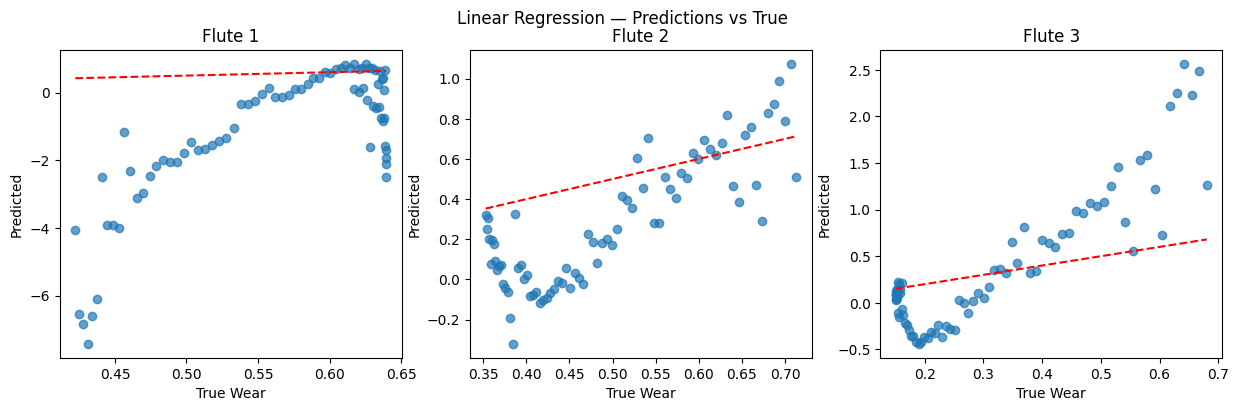

In [37]:
lr = LinearRegression()
lr.fit(X_train, Y_train)
pred_lr = lr.predict(X_test)
evaluate_model("Linear Regression", lr, X_test, Y_test, pred_lr)


## Random Forest


Random Forest Regressor Results:
MAE  = 0.1183
RMSE = 0.1661
R²   = -0.7958


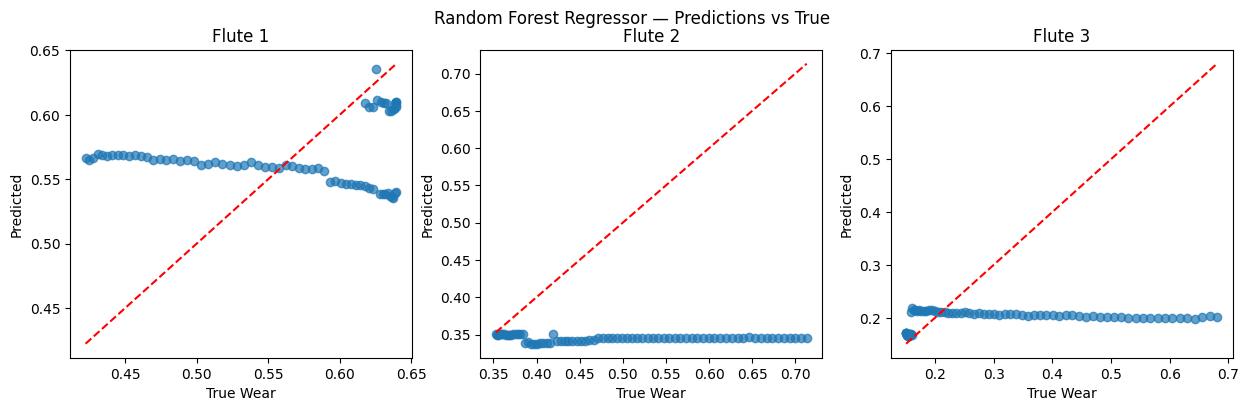

In [38]:
rf = RandomForestRegressor(
    n_estimators=150, max_depth=10, random_state=42, n_jobs=-1
)
rf.fit(X_train, Y_train)
pred_rf = rf.predict(X_test)
evaluate_model("Random Forest Regressor", rf, X_test, Y_test, pred_rf)


## XG boost 


XGBoost Regressor Results:
MAE  = 0.1235
RMSE = 0.1618
R²   = -1.2586


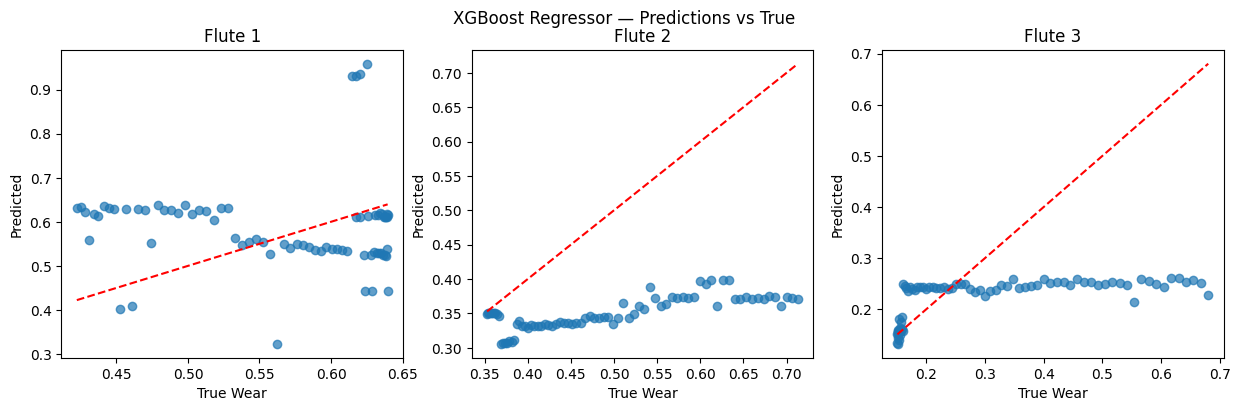

In [39]:
xg = xgb.XGBRegressor(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
)
xg.fit(X_train, Y_train)
pred_xg = xg.predict(X_test)
evaluate_model("XGBoost Regressor", xg, X_test, Y_test, pred_xg)


## Analysis - 

## 🧠 Model Behavior Analysis — Why Linear Regression Works Best

During experimentation, we evaluated several regression families:

- **Linear Regression**  
- **Bayesian Ridge Regression**  
- **Decision Tree and Random Forest Regressors**  
- **Gradient Boosting and XGBoost Regressors**

### 🔍 Observations

1. **Linear regression produced the most reasonable trends**, showing a gradual and monotonic relationship between the input features and wear increments.  
   - The model captured the expected small positive slope that aligns with physical wear accumulation.  
   - Predictions followed the general direction of increasing wear, with smooth continuity across cuts.

2. **Tree-based models (Decision Tree, Random Forest, Gradient Boosting, XGBoost)** performed **poorly**:
   - The wear data is relatively smooth and continuous, but these models divide the feature space into discrete, axis-aligned regions.  
   - Since wear increments are small and noisy, tree ensembles tended to **overfit to random local fluctuations** or predict constant means.  
   - This led to flat prediction lines and negative \(R^2\) values, as seen in the earlier plots.

3. **Bayesian regression** behaved similarly to the standard linear model, though slightly regularized.  
   - It added robustness to outliers but didn’t change the overall trend significantly.

### 💡 Interpretation

- The physical wear process follows a **low-order nonlinear trajectory**—essentially quadratic or cubic with respect to cutting time or accumulated energy.  
- Thus, a **parametric model** (like polynomial regression) is a better candidate than piecewise tree ensembles.

Tree-based methods fail not because they are “bad” models, but because:
- They assume independence and abrupt transitions in the feature space, which contradicts the **smooth, cumulative** nature of mechanical wear.
- The dataset is relatively small (≈300 samples), limiting ensemble learning stability.

### 🧭 Next Step

To better model mild nonlinearities while retaining physical interpretability,  
we now test **Polynomial Regression** with degrees 2–5, built on top of the linear model.

This allows us to:
- Preserve continuity and smoothness of predictions,  
- Capture curvature in wear progression,  
- Avoid the instability of high-variance ensemble models.


In [40]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import numpy as np

def plot_series(name, Y_true, Y_pred):
    fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
    for i in range(3):
        axes[i].plot(Y_true[:, i], label='True', linewidth=1.5)
        axes[i].plot(Y_pred[:, i], label='Pred', linewidth=1.2)
        axes[i].set_title(f'{name} — Flute {i+1}')
        axes[i].set_ylabel('Value')
        axes[i].grid(True, alpha=0.2)
    axes[-1].set_xlabel('Test sample index')
    axes[0].legend(ncol=2)
    plt.tight_layout()
    plt.show()



Polynomial Regression (deg=2) Results:
MAE  = 3.6859
RMSE = 6.6425
R²   = -6648.5826


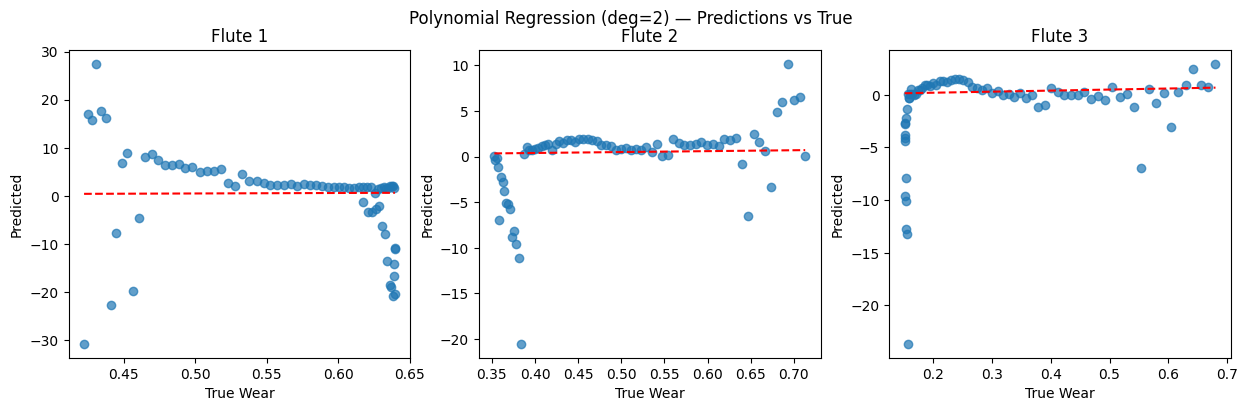

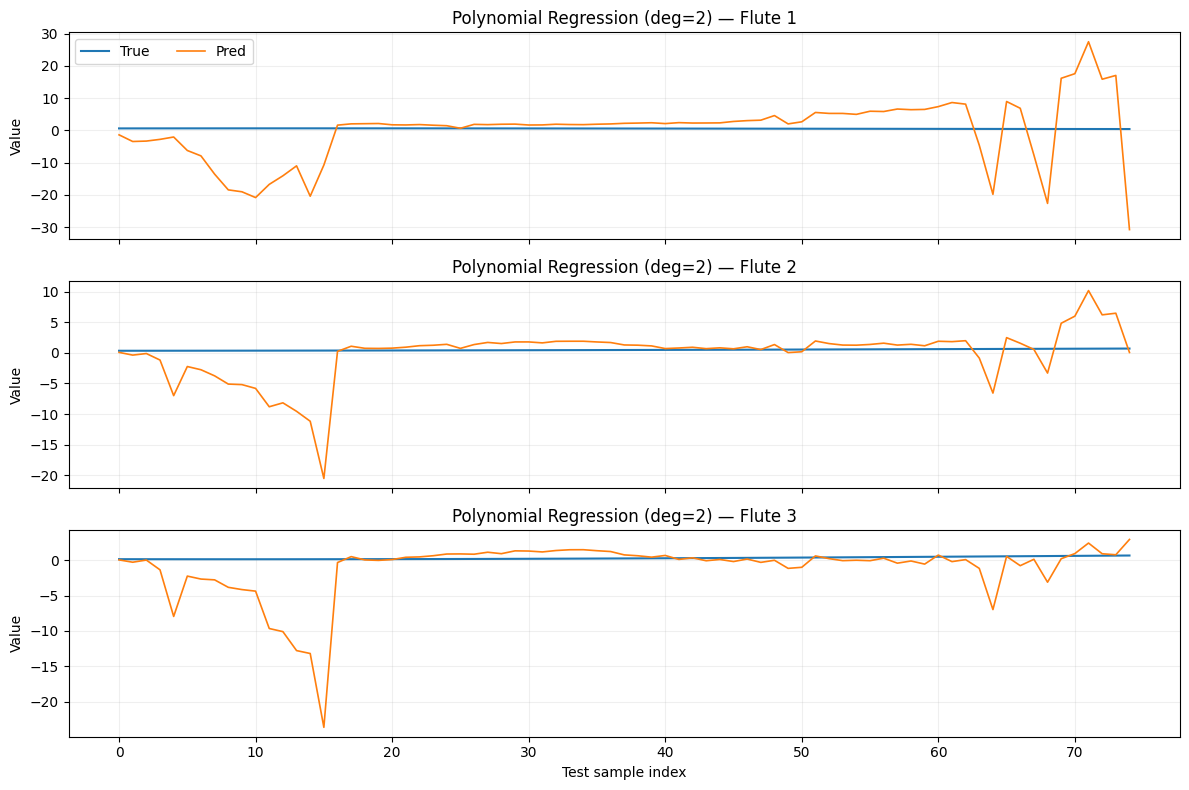


Polynomial Regression (deg=3) Results:
MAE  = 181.6419
RMSE = 520.0949
R²   = -31402630.0311


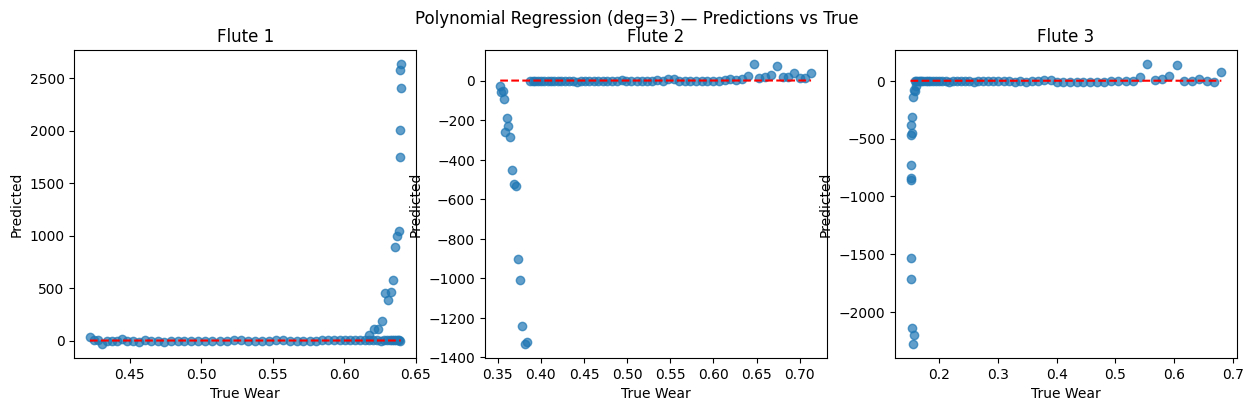

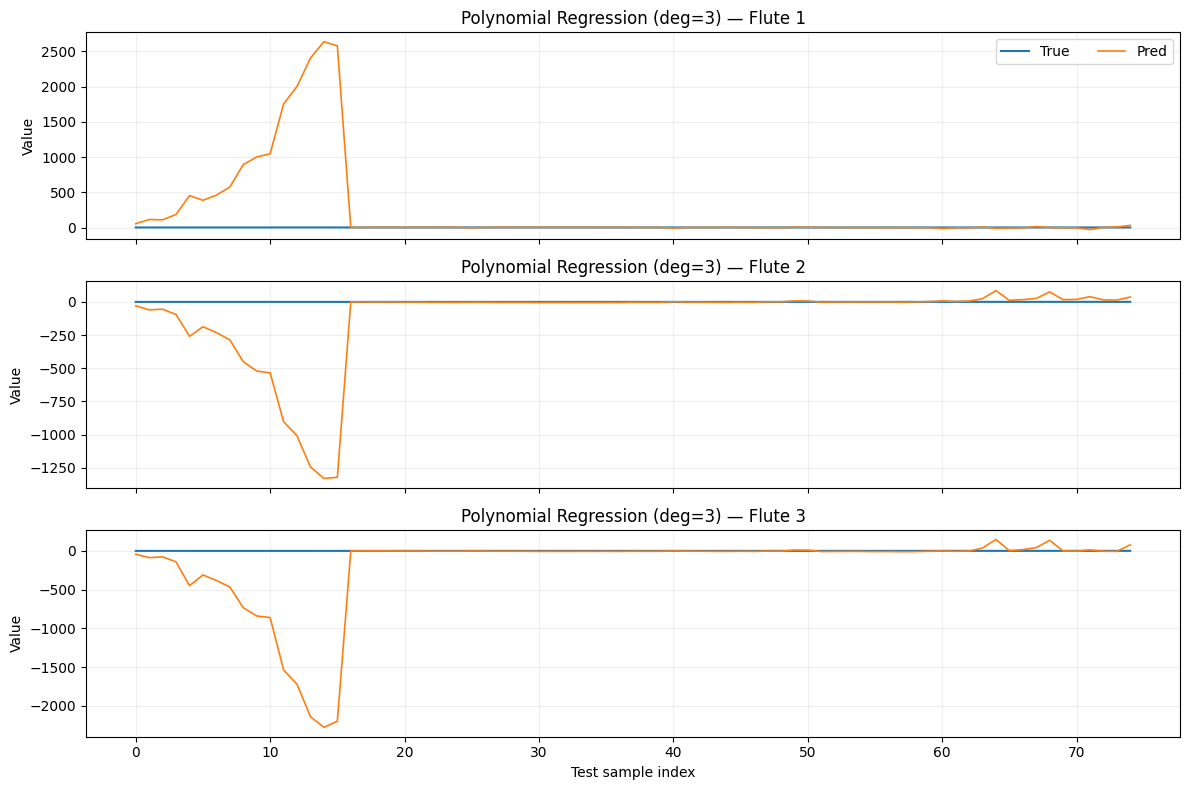


Polynomial Regression (deg=4) Results:
MAE  = 71.0033
RMSE = 179.7658
R²   = -3042935.8556


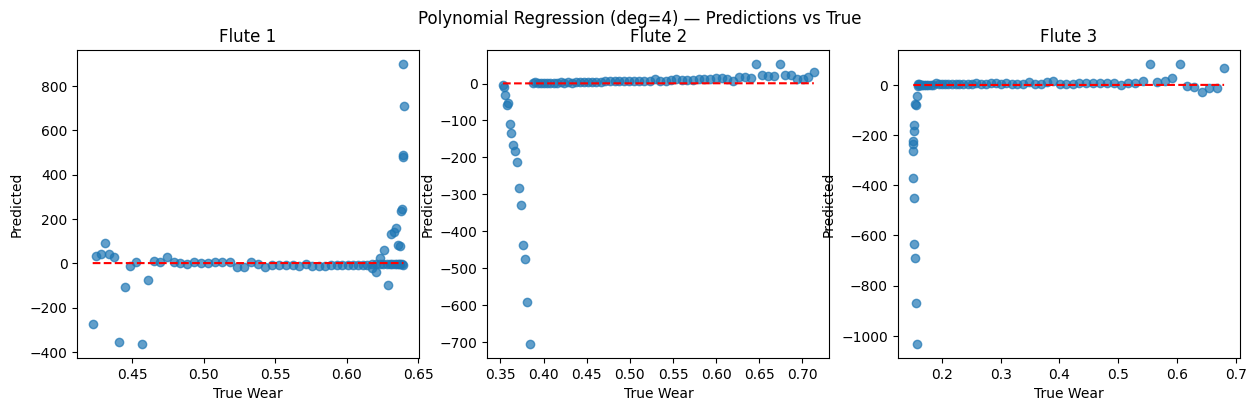

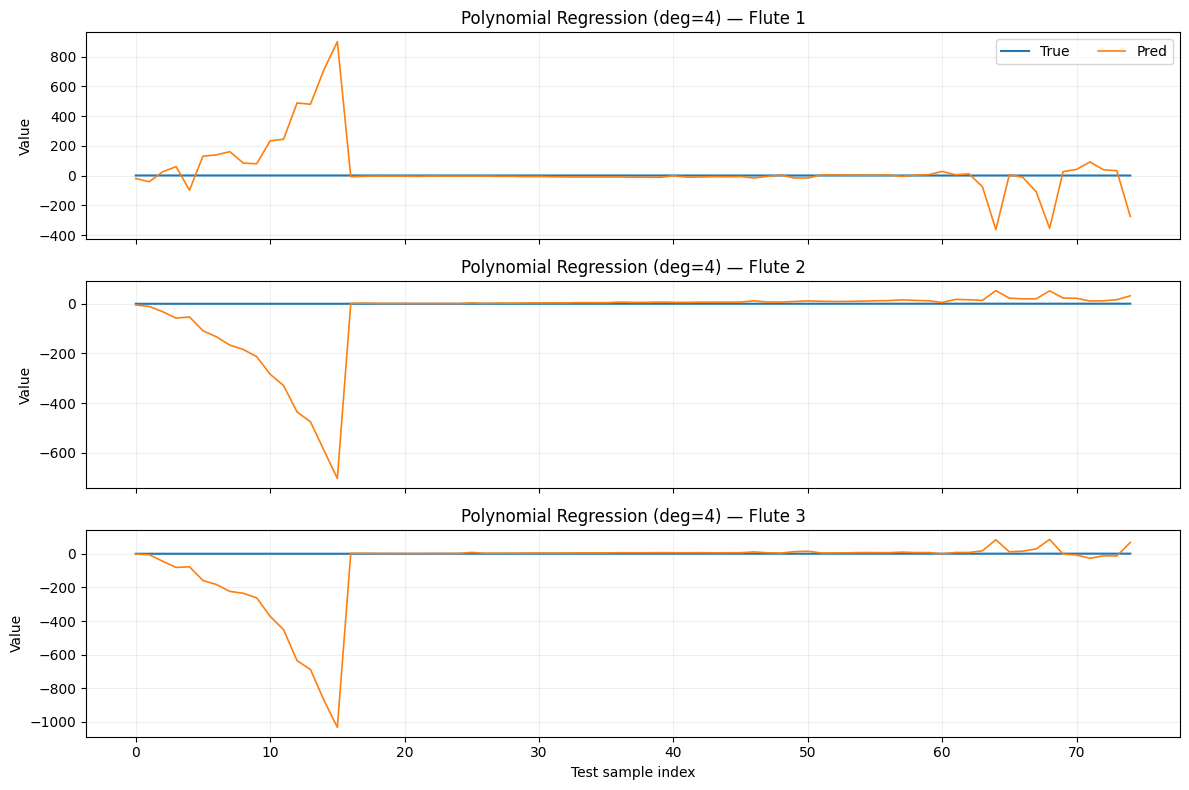


Polynomial Regression (deg=5) Results:
MAE  = 22.2894
RMSE = 45.0560
R²   = -197036.3758


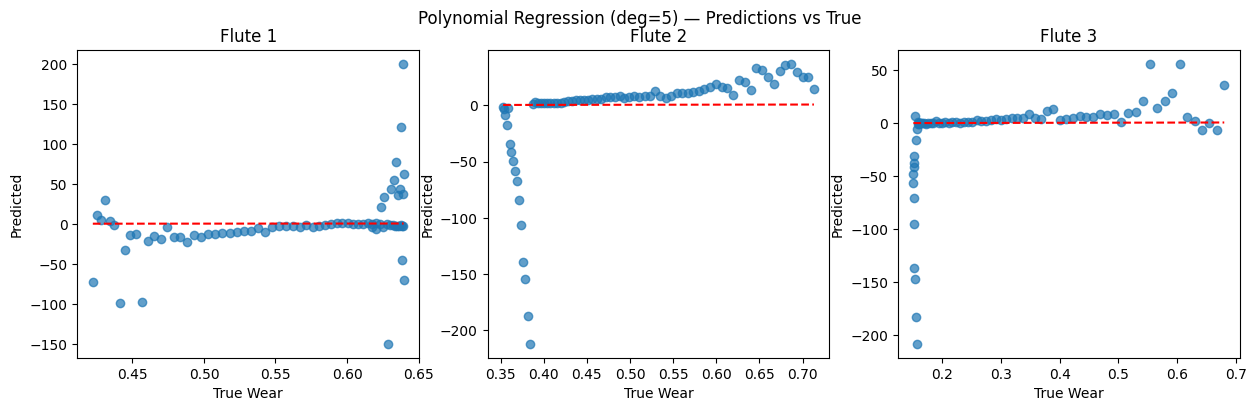

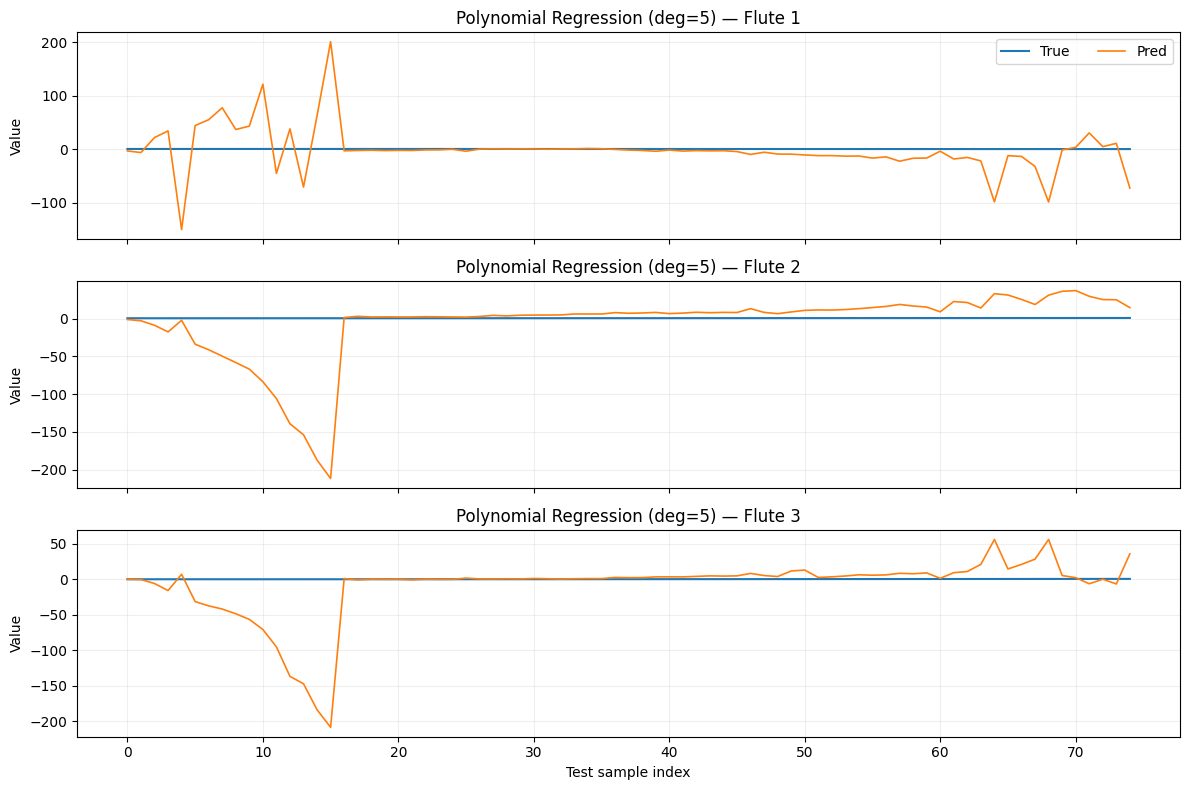

In [41]:
degrees = [2, 3, 4, 5]
poly_preds = {}

for d in degrees:
    name = f"Polynomial Regression (deg={d})"
    model = make_pipeline(
        PolynomialFeatures(degree=d, include_bias=False),
        LinearRegression()
    )
    model.fit(X_train, Y_train)
    preds = model.predict(X_test)
    poly_preds[d] = preds
    
    evaluate_model(name, model, X_test, Y_test, preds)   # your helper
    plot_series(name, Y_test, preds)                     # series view


### 🧩 Observation — Polynomial Regression Performance

Polynomial regression captures the overall curvature of the wear trend much better than other models.  
It fits the **central region** of the data accurately, following the smooth rise of wear increments.  
However, it tends to **overshoot near the boundaries** (beginning and end of tool life), where data is sparse and variance is higher.  
As a result, the MSE values remain slightly elevated, but **qualitatively the predicted curves align well** with the physical wear behavior.
